## インストール
```
pip install google-cloud-bigquery
```

In [62]:
## 必要なライブラリをインポート
import os
import pandas as pd  
import numpy as np
from dotenv import load_dotenv
from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
##GCM
from google.cloud import bigquery
from google.oauth2 import service_account
## scikit-learnライブラリ
from sklearn.cluster import KMeans
## .envファイル読込み
load_dotenv()
sekyurity_pass = os.environ['SEKYURITYPASS']
server_name = os.environ['SERVERNAME']

# BigQueryクライアントの初期化
def set_client(key_path):
  try:
      credentials = service_account.Credentials.from_service_account_file(key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"])
      client =  bigquery.Client(credentials=credentials, project=credentials.project_id)
      return client
  except Exception as e:
      print(f"Failed to initialize BigQuery client: {e}")
      return None

def read_all_data(client,table_id):
    query = f"""
    SELECT
        *
    FROM 
        `{table_id}`;
    """
    bq_result = client.query(query)
    df = pd.DataFrame([dict(row) for row in bq_result])
    return df

def read_limit_data(client,table_id,num):
    query = f"""
    SELECT
        *
    FROM 
        `{table_id}`
    LIMIT {num};
    """
    bq_result = client.query(query)
    df = pd.DataFrame([dict(row) for row in bq_result])
    return df

def read_query_data(client,table_id,query_str):
    bq_result = client.query(query_str)
    df = pd.DataFrame([dict(row) for row in bq_result])
    return df

In [ ]:
'''
BigQueryから返されるクエリ結果のイテレータ
各行がRowオブジェクトとして返され、各Rowは辞書のように振る舞います。

# 最初の行を取得
first_row = next(iter(bq_result))
# 行のデータを確認
print(first_row)
print(type(first_row))

# DataFrameに変換
df = pd.DataFrame([dict(row) for row in bq_result])
df
'''

In [63]:
# 前ステップでダウンロードした service-account-key-file.jsonのフルパスを指定
client = set_client(key_path=sekyurity_pass)
data_base = "sandbox.access_log_ga4"
table_id = server_name + data_base
df = read_limit_data(client,table_id,5)
df

,user_pseudo_id,session_num,pv_num,purchase_num
0,6283830.7324898117,12,155,0
1,7385163302.4274482131,12,92,1
2,9175563.4519041873,12,80,0
3,77419838.9395198381,12,45,0
4,29392387.1914586824,12,39,0


In [6]:
## 型定義
ga4_log_db_type={'user_pseudo_id':str, 'session_num':int,'pv_num':int,'purchase_num':int}
## csvから読み込み
df = pd.read_csv('./data/access_log_ga4.csv', dtype=ga4_log_db_type)
df

,user_pseudo_id,session_num,pv_num,purchase_num
0,6283830.7324898117,12,155,0
1,7385163302.4274482131,12,92,1
2,9175563.4519041873,12,80,0
3,77419838.9395198381,12,45,0
4,29392387.1914586824,12,39,0
...,...,...,...,...
94785,31590258.3073450050,1,0,0
94786,69112514.4276575294,1,0,0
94787,88201008.2913748005,1,0,0
94788,8937879024.4560779602,1,0,0


In [7]:
## 不要なカラムを削除
df = df.drop("user_pseudo_id",axis=1)
df

,session_num,pv_num,purchase_num
0,12,155,0
1,12,92,1
2,12,80,0
3,12,45,0
4,12,39,0
...,...,...,...
94785,1,0,0
94786,1,0,0
94787,1,0,0
94788,1,0,0


In [8]:
## クラスタ分析
km = KMeans(n_clusters=3)
cluster = km.fit_predict(df)
cluster

array([2, 2, 2, ..., 1, 1, 1], dtype=int32)

In [9]:
## dfに新たにclusterカラムを用意し、クラスタ分析の結果を挿入
df['cluster'] = cluster
df

,session_num,pv_num,purchase_num,cluster
0,12,155,0,2
1,12,92,1,2
2,12,80,0,2
3,12,45,0,0
4,12,39,0,0
...,...,...,...,...
94785,1,0,0,1
94786,1,0,0,1
94787,1,0,0,1
94788,1,0,0,1


In [10]:
## クラスターのデータ数を確認
df['cluster'].value_counts()

cluster
1    90409
0     3954
2      427
Name: count, dtype: int64

In [15]:
## 各クラスターごとの平均値を確認
pd.concat([df.groupby('cluster').mean(),df['cluster'].value_counts()],axis=1)

,session_num,pv_num,purchase_num,count
cluster,,,,
0,2.862418,25.722054,0.200303,3954
1,1.162451,3.081607,0.001217,90409
2,4.604215,90.618267,0.707260,427


## 最適なクラスターを探す

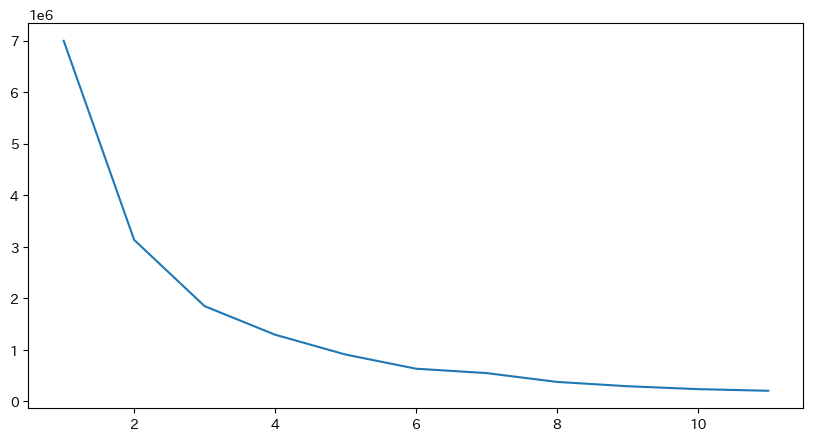

In [18]:
## 2乗誤差の総和を求めて可視化
sse_list = []
for i in range(1,12):
  km = KMeans(n_clusters=i)
  cluster = km.fit_predict(df)
  sse = km.inertia_
  sse_list.append(sse)

plt.figure(figsize=(10,5))
plt.plot(range(1,12), sse_list)
plt.show()

In [20]:
# 5の辺りで傾斜が緩やかになるため、クラスター数は５でセット
df = pd.read_csv('./data/access_log_ga4.csv', dtype=ga4_log_db_type)
df = df.drop("user_pseudo_id",axis=1)
km = KMeans(n_clusters=5)
cluster = km.fit_predict(df)
df['cluster'] = cluster
pd.concat([df.groupby('cluster').mean(),df['cluster'].value_counts()],axis=1)

,session_num,pv_num,purchase_num,count
cluster,,,,
0,1.121562,2.683354,0.000058,86055
1,3.594233,40.395921,0.354430,1422
2,2.190157,14.222397,0.065906,7010
3,6.142857,356.428571,2.142857,7
4,4.584459,96.118243,0.736486,296
